# Frequency Tagging

In [1]:
import mne
import pandas as pd
import numpy as np
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper, AverageTFR
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

## Simulation

Check out Lecture 2! Especially the evoked and induced bit.

## High frequency stimulation

This tutorial uses EEG data provided by Tzvetan Popov accompanying [this paper](https://www.frontiersin.org/articles/10.3389/fnins.2018.00711/full). Participants listen to 500 Hz pure tones, amplitude modulated (100% depth) at 40 Hz. Tones are of 2 second duration. Overall 120 stimuli were presented.

The following code let's you play around, with various parameters, how the stimuli could look like. Note that for visualization purposes a slow rate is chosen.

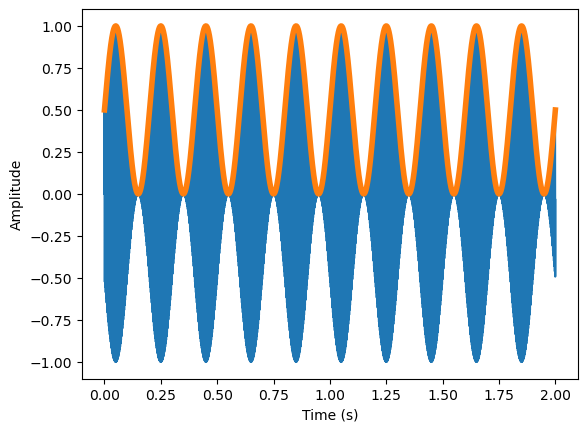

In [30]:
fs = 44100
t = np.arange(0, 2, 1/fs)
f = 500 # frequency in Hz
A = 1 # amplitude
sine_wave = A * np.sin(2*np.pi*f*t)

mod_f = 5 # modulation frequency in Hz
mod_A = 1 # modulation amplitude
mod_wave = (1 + mod_A * np.sin(2*np.pi*mod_f*t)) / 2
modulated_wave = sine_wave * mod_wave

plt.plot(t, modulated_wave)
plt.plot(t, mod_wave, linewidth=4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


We will grab one of the EEG datasets provided by Tzvetan and use very similar preprocessing parameters as in his tutorial.

In [3]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture5_FrequencyTagging/data/"

raw = mne.io.read_raw_egi(datapath + '45048.RAW', preload = True)
raw.drop_channels(['E30', 'E192', 'E257'])
#raw.rename_channels({'E257': 'Cz'})
raw.set_montage('EGI_256')
raw.notch_filter(freqs=(50, 100, 150, 200))
raw.filter(2, 48)

evts = mne.find_events(raw)
epochs= mne.Epochs(raw, evts, tmin=-1, tmax=3, preload = True)

Reading EGI header from /Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture5_FrequencyTagging/data/45048.RAW...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {DIN1} ...
Reading 0 ... 367599  =      0.000 ...   367.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.2s


125 events found
Event IDs: [1 2 3]
Not setting metadata
125 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 4001 original time points ...
0 bad epochs dropped


Let's plot the evoked responses. Tone stimulation is between 0-2 seconds. Can you see oscillations?

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


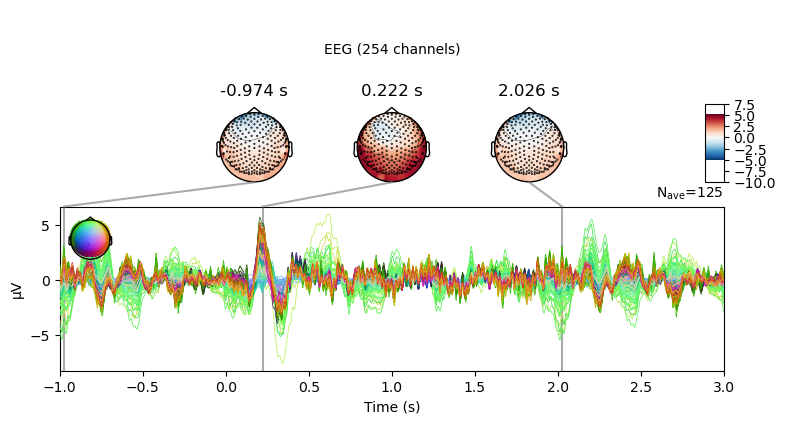

In [4]:
evoked = epochs.copy().average()
evoked.plot_joint();


We will take the evoked response and perform a spectral analysis for the period of sound stimulation.

Effective window size : 2.001 (s)


/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


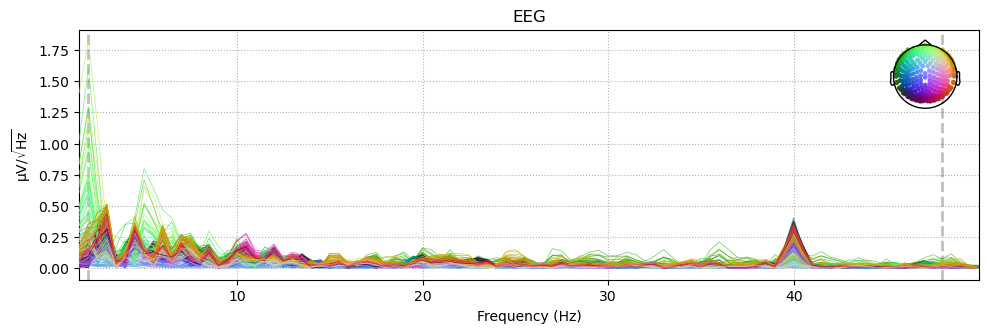

In [5]:
psdevoked = evoked.copy().crop(0, 2).compute_psd(method='welch', fmin=1, fmax=50)
psdevoked.plot(dB = False);

Based on the spectrum, we will find the electrode with the largest 40 Hz response and plot the ERP.

Need more than one channel to make topography for eeg. Disabling interactivity.


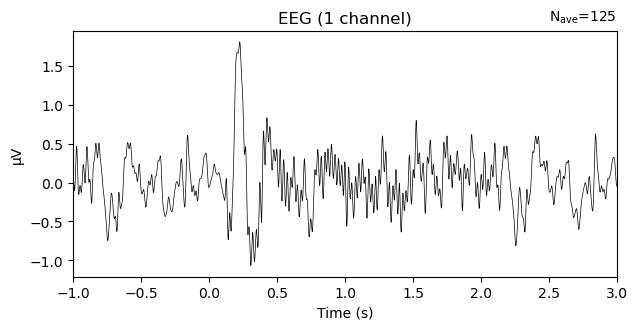

In [6]:
ind40Hz = (np.abs(psdevoked.freqs - 40)).argmin()
evoked.plot(picks = evoked.ch_names[ind40Hz]);



Do you see the oscillatory response?

### Derive SSR from TFR

When we do SSR or frequency tagging analysis, we solely focus on the stimulation frequency and can ignore the rest. There are different ways of extracting the response. One was shown above (power spectrum on ERP). However it lost the temporal information. To maintain information on temporal dynamics we need to employ time-frequency techniques.

Let's contrast evoked and induced TFRs.

In [7]:
freqs = np.arange(2, 48) 

tfr_evoked = tfr_multitaper(
    evoked,
    freqs=freqs,
    n_cycles=freqs / 2, #500 ms windo 
    time_bandwidth=2,
    use_fft=True,
    return_itc=False,
    decim=2,
)

tfr_induced = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs / 2, #500 ms windo 
    time_bandwidth=2,
    use_fft=True,
    return_itc=True,
    decim=2,
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  2.5min


The following code plots the evoked TFR.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


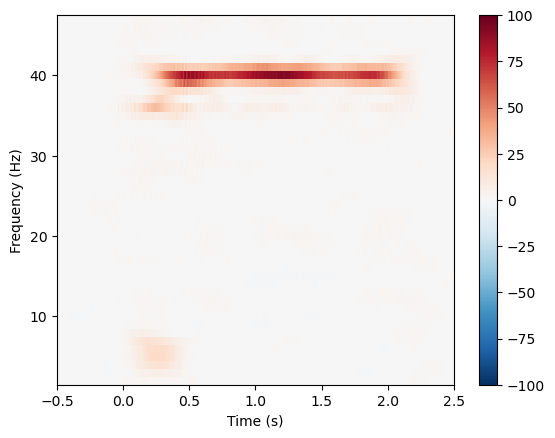

[<Figure size 640x480 with 2 Axes>]

In [8]:
tfr_evoked.plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-100, vmax=100)   

The following code plots the induced TFR.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


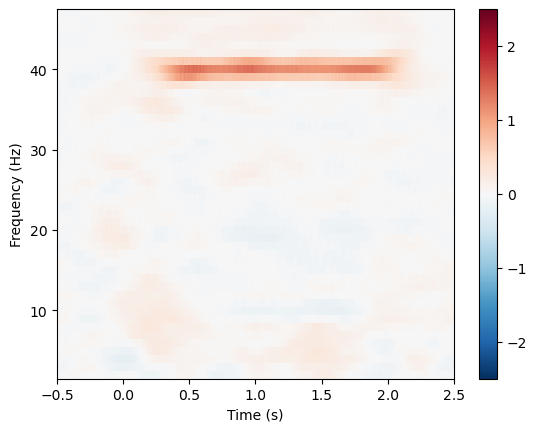

[<Figure size 640x480 with 2 Axes>]

In [9]:
tfr_induced[0].plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-2.5, vmax=2.5)  

This analysis shows that power increases are present at the level of single trials. This is not always the case. Anyhow, as you can see from the scales the TFR of the evoked response is much “crisper“.

The code to run the induce power analysis explicitly instructed to return the Inter Trial Coherence (ITC). This measure is based on the phase consistency over single trial. Let's take a look at the output.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


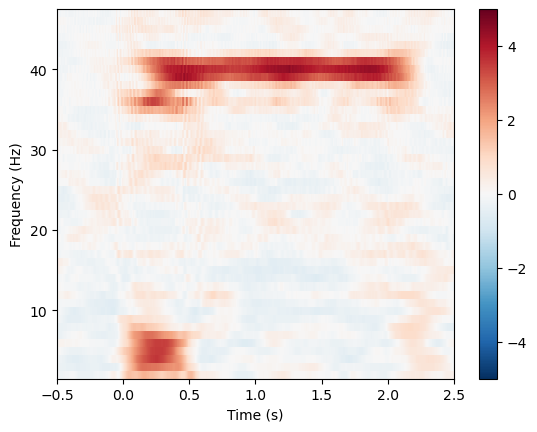

[<Figure size 640x480 with 2 Axes>]

In [10]:
tfr_induced[1].plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-5, vmax=5)  

In our last approach, similar to the featured paper by Pan et al. (2021), we will use coherence with reference signal as measure of the rhythmic neural response.

For this we will generate a 40 Hz sine wave, and *add it to the existing EEG data as an additional channel*.

In [11]:
fs = 1000
t = np.arange(0, 2, 1/fs)
f = 40 # frequency in Hz
A = 1 # amplitude
sine_wave = A * np.sin(2*np.pi*f*t)

stimsig = np.concatenate([np.zeros((1000,)), sine_wave, np.zeros((1001,))])
stimsig3D = np.tile(stimsig, (125, 1)).reshape(125, 1, -1)

info = mne.create_info(['StimSig'], ch_types = ["misc"], sfreq=1000)
epochs_stim = mne.EpochsArray(stimsig3D, info)

newepochs = epochs.copy().add_channels([epochs_stim],force_update_info=True)



Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


We will then create a list of arrays, that define between which channels coherence is supposed to be computed. Here it is our “pseudo“-stimulus-channel with all EEG channels. 

In [12]:
picks = mne.pick_types(newepochs.info, eeg=True)

indices = (np.repeat(len(newepochs.ch_names)-1,len(picks)),    # row indices
          picks)

con = spectral_connectivity_epochs(
    newepochs, indices=indices,
    method='coh', mode='multitaper', 
    mt_bandwidth = 2,
    fmin = 2, fmax = 48, n_jobs=1)

Adding metadata with 3 columns
Connectivity computation...
    computing connectivity for 254 connections
    using t=-1.000s..3.000s for estimation (4001 points)
    frequencies: 2.2Hz..48.0Hz (184 points)


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing 

We can plot the coherence spectrum.

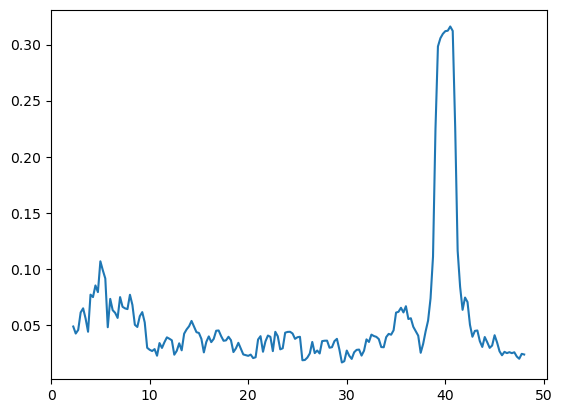

In [13]:
plt.plot(con.freqs, np.mean(con.get_data(), axis = 0))

The previous analysis does not include temporal information. We change this in the following analysis.

In [14]:
#con_tfr = spectral_connectivity_time(newepochs, indices=indices,

cwt_freqs = np.arange(10, 48, 2)
cwt_n_cycles = cwt_freqs / 2.

con_tfr = spectral_connectivity_epochs(newepochs, indices=(np.array([259]),np.array([ind40Hz])),
    method='coh', mode='cwt_morlet',  
    cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles)

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=-1.000s..3.000s for estimation (4001 points)
    frequencies: 10.0Hz..46.0Hz (19 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
   

/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:270: RuntimeWarning: invalid value encountered in divide
  self.con_scores[con_idx] = np.abs(csd_mean) / np.sqrt(psd_xx * psd_yy)


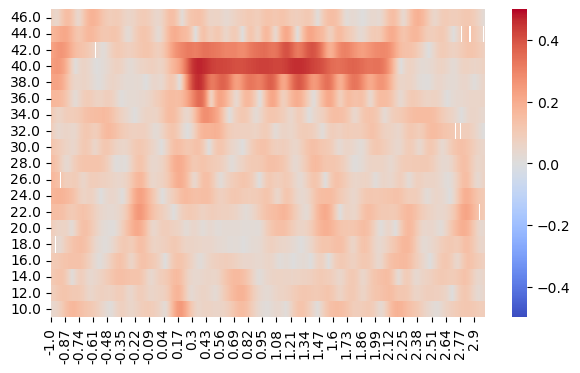

In [15]:
cohMat = np.squeeze(con_tfr.get_data())
df_coh = pd.DataFrame(data=cohMat, columns=con_tfr.times, index=con_tfr.freqs)

plt.figure(figsize = (7,4))
ax = sns.heatmap(df_coh, vmin = -.5, vmax = .5, cmap = "coolwarm")
ax.invert_yaxis()
plt.show()

## Low frequency stimulation

“Tracking“ rhythmic stimulation is also very popular in auditory research. Usually the interest is at lower stimulation frequencies. We will use data from our tone sequences, to see whether we can capture the rhytmic stimulation.

Adding metadata with 3 columns
2845 matching events found
No baseline correction applied
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


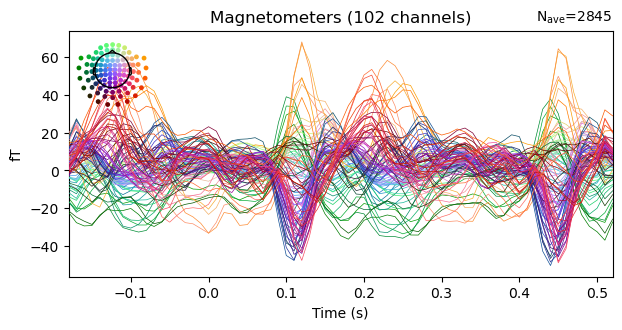

In [16]:
info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=100)

datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture3_Decoding/data/dataset4nathan.mat"
epochs3Hz = mne.read_epochs_fieldtrip(datapath, info)

evoked3Hz = epochs3Hz.copy().average()
evoked3Hz.plot();

For the sake of simplicity, we will do a spectral analysis on the evoked reponse, aka “evoked power“.

Effective window size : 0.710 (s)


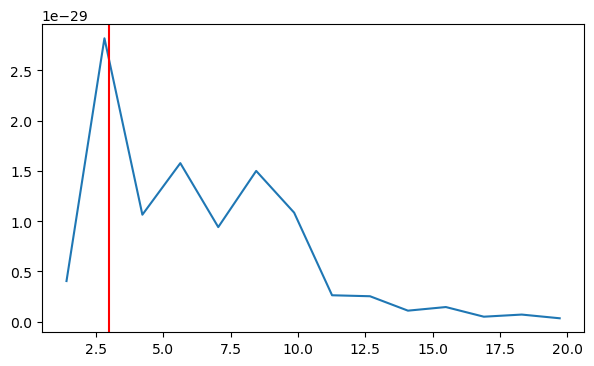

In [17]:
psdevoked3HZ = evoked3Hz.copy().compute_psd(method='welch', fmin=1, fmax=20)

plt.figure(figsize = (7,4))
plt.plot(psdevoked3HZ.freqs, psdevoked3HZ.get_data().mean(axis=0));
plt.axvline(x = 3, color = 'r');

**The peak is not exactly at 3 Hz (indicated by red line). Why?**